In [1]:
import os

import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import numpy as np
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [97]:
TABLE_NAME = "users_churn" # таблица с данными в postgres 

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "Data_Exploration" # напишите название вашего эксперимента
RUN_NAME = "eda"

ASSETS_DIR = "assets"

os.makedirs(ASSETS_DIR, exist_ok=True)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid")

In [14]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

#df.dropna(inplace=True)
df.head(2)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,1,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,None,0
1,2,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,0


/tmp/ipykernel_6270/983467271.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45);
/tmp/ipykernel_6270/983467271.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 1].set_xticklabels(df[x].unique());
/tmp/ipykernel_6270/983467271.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(df[x].unique());


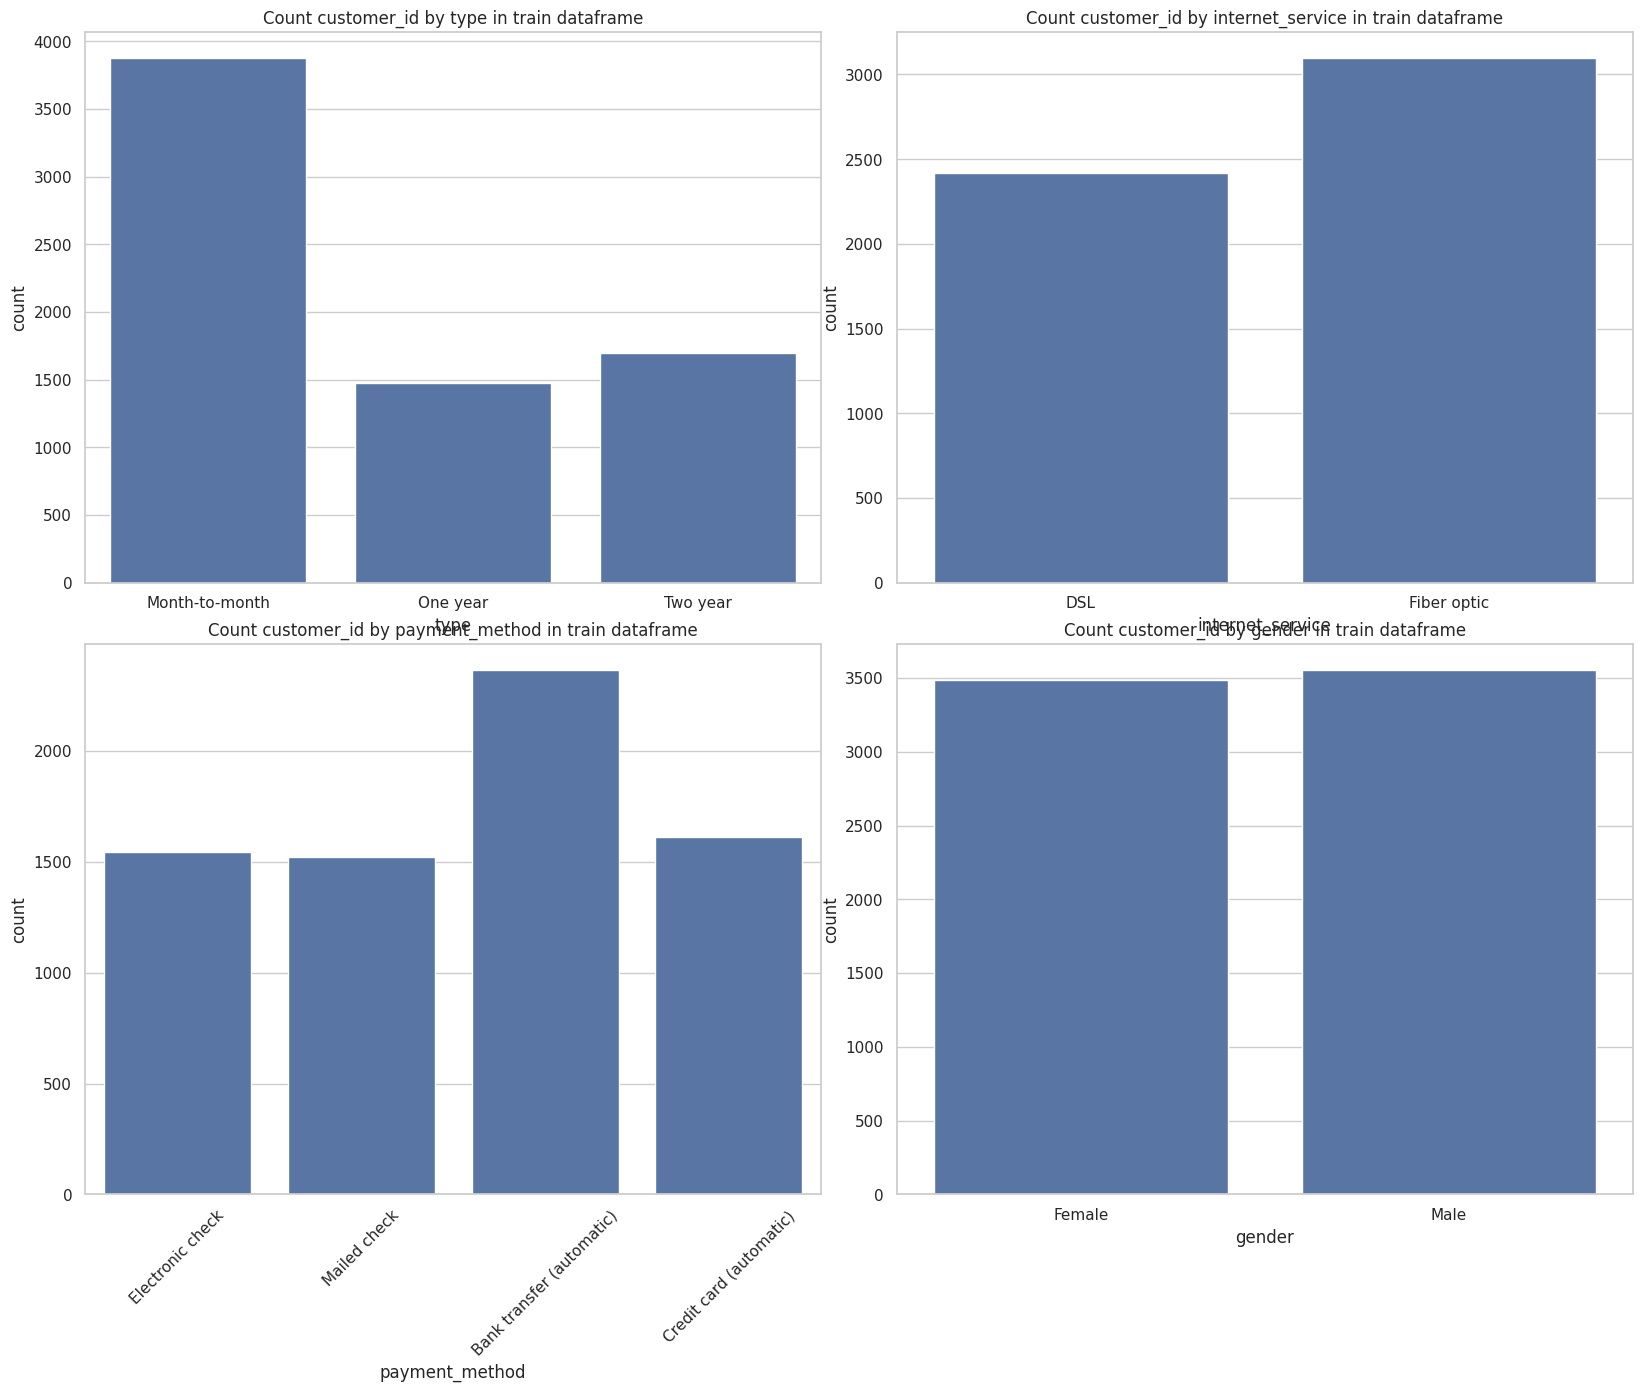

In [5]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=1.6)


x = "type"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(by=x, as_index=False).agg({y : stat[0]}).rename(columns={y : stat[0]})
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 0])
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')

x = "payment_method"
y = "customer_id"
agg_df = df.groupby(by=x, as_index=False).agg({y : stat[0]}).rename(columns={y : stat[0]})
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 0])
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')

axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45);

x = "internet_service"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(by=x, as_index=False).agg({y : stat[0]}).rename(columns={y : stat[0]})
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 1])
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')
axs[0, 1].set_xticklabels(df[x].unique());

x = "gender"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(by=x, as_index=False).agg({y : stat[0]}).rename(columns={y : stat[0]})
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 1])
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 1].set_xticklabels(df[x].unique());

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_1'))

In [6]:
x = "customer_id"
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]
stat = ['count']

df.groupby(binary_columns).agg(stat[0])[x].reset_index().sort_values(by=x, ascending=False).head(10)

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,senior_citizen,partner,dependents,customer_id
0,No,No,No,No,No,No,0,No,No,371
106,No,Yes,No,No,No,No,0,No,No,105
414,Yes,Yes,Yes,Yes,Yes,Yes,0,Yes,Yes,103
4,No,No,No,No,No,No,1,No,No,101
8,No,No,No,No,No,Yes,0,No,No,90
15,No,No,No,No,Yes,No,0,No,No,86
214,Yes,No,No,No,No,No,0,No,No,83
22,No,No,No,No,Yes,Yes,0,No,No,82
413,Yes,Yes,Yes,Yes,Yes,Yes,0,Yes,No,75
3,No,No,No,No,No,No,0,Yes,Yes,68


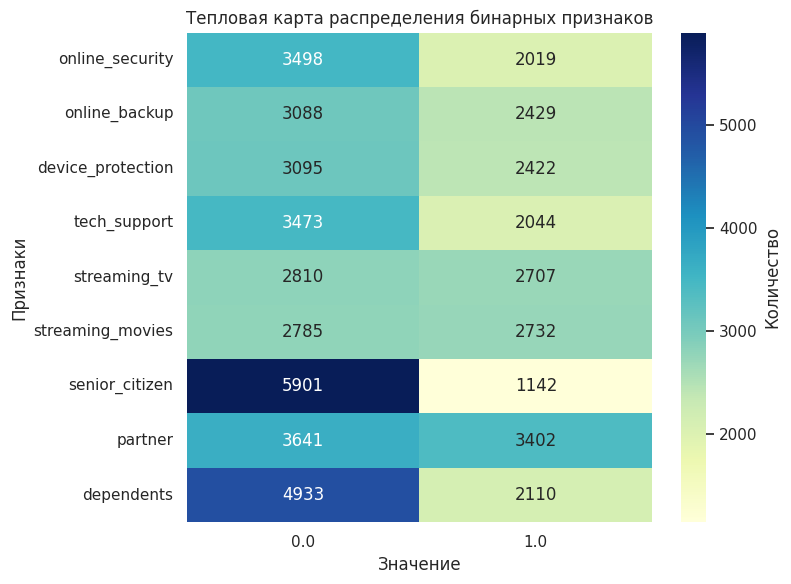

In [7]:
heat_df = df[binary_columns].replace({'Yes' : 1, 'No' : 0}).apply(pd.Series.value_counts).T

# Построение тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(heat_df, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Количество'})
plt.xlabel("Значение")
plt.ylabel("Признаки")
plt.title("Тепловая карта распределения бинарных признаков")
plt.tight_layout()
plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_2_binary_heatmap'))

plt.show()

In [8]:
# инициализация переменной для названия колонки
x = "begin_date"

# список колонок, для которых будут вычисляться статистики
charges_columns = [
    "monthly_charges",
    "total_charges",
]

# удаление пустых колонок для посчёта медианного значения
df.dropna(subset=charges_columns, how='any', inplace=True)

# список статистик, которые будут вычисляться для каждой группы
stats = ["mean", "median", lambda x: x.mode().iloc[0]]  # среднее значение, медиана и мода

# группировка данных по дате начала и агрегация статистик для ежемесячных платежей (используйте reset_index для сброса индекса в таблице)
charges_monthly_agg = df.groupby(x, as_index=False).agg({charges_columns[0] : stats})
# удаление верхнего уровня индекса колонок (после агрегации)
charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()
# переименование колонок для удобства восприятия
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

# аналогично для общих платежей
charges_total_agg = df.groupby(x, as_index=False).agg({charges_columns[1] : stats})
charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

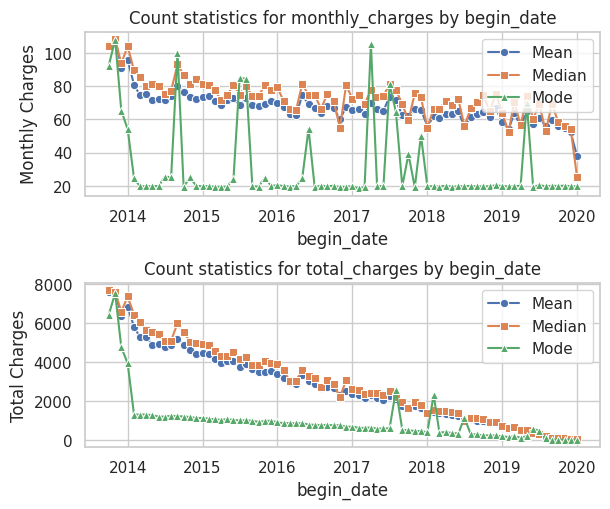

In [9]:
fig, axs = plt.subplots(2, 1)
# настройка отступов между графиками
fig.tight_layout(pad=2.5)
# установка размера фигуры
fig.set_size_inches(6.5, 5.5, forward=True)

# Построение линейных графиков для ежемесячных платежей
sns.lineplot(data=charges_monthly_agg, x=x, y="monthly_mean", label="Mean", ax=axs[0], marker="o")
sns.lineplot(data=charges_monthly_agg, x=x, y="monthly_median", label="Median", ax=axs[0], marker="s")
sns.lineplot(data=charges_monthly_agg, x=x, y="monthly_mode", label="Mode", ax=axs[0], marker="^")

axs[0].set_xlabel(x)
axs[0].set_ylabel("Monthly Charges")
axs[0].legend()
axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")

# Построение линейных графиков для общих платежей
sns.lineplot(data=charges_total_agg, x=x, y="total_mean", label="Mean", ax=axs[1], marker="o")
sns.lineplot(data=charges_total_agg, x=x, y="total_median", label="Median", ax=axs[1], marker="s")
sns.lineplot(data=charges_total_agg, x=x, y="total_mode", label="Mode", ax=axs[1], marker="^")

axs[1].set_xlabel(x)
axs[1].set_ylabel("Total Charges")
axs[1].legend()
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")

plt.savefig(os.path.join(ASSETS_DIR, 'charges_by_date'))

plt.show()

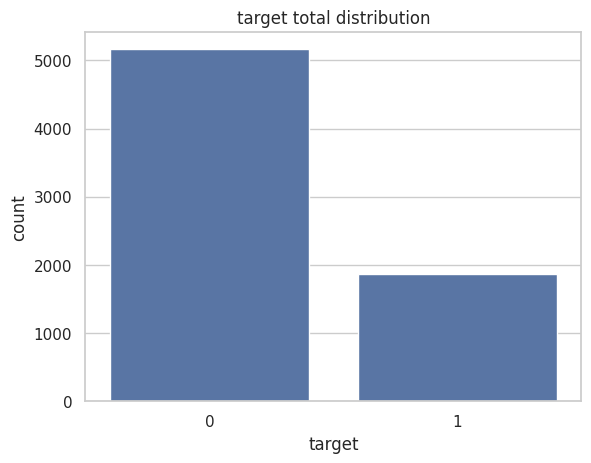

In [10]:
x = "target"

# подсчёт количества каждого уникального значения в колонке и сброс индекса для последующей визуализации
target_agg = df[x].value_counts().reset_index()
# создание столбчатой диаграммы для визуализации распределения целевой переменной
sns.barplot(data=target_agg, x=x, y='count')
# установка заголовка графика
plt.title(f"{x} total distribution")

plt.savefig(os.path.join(ASSETS_DIR, 'target_count'))
plt.show()

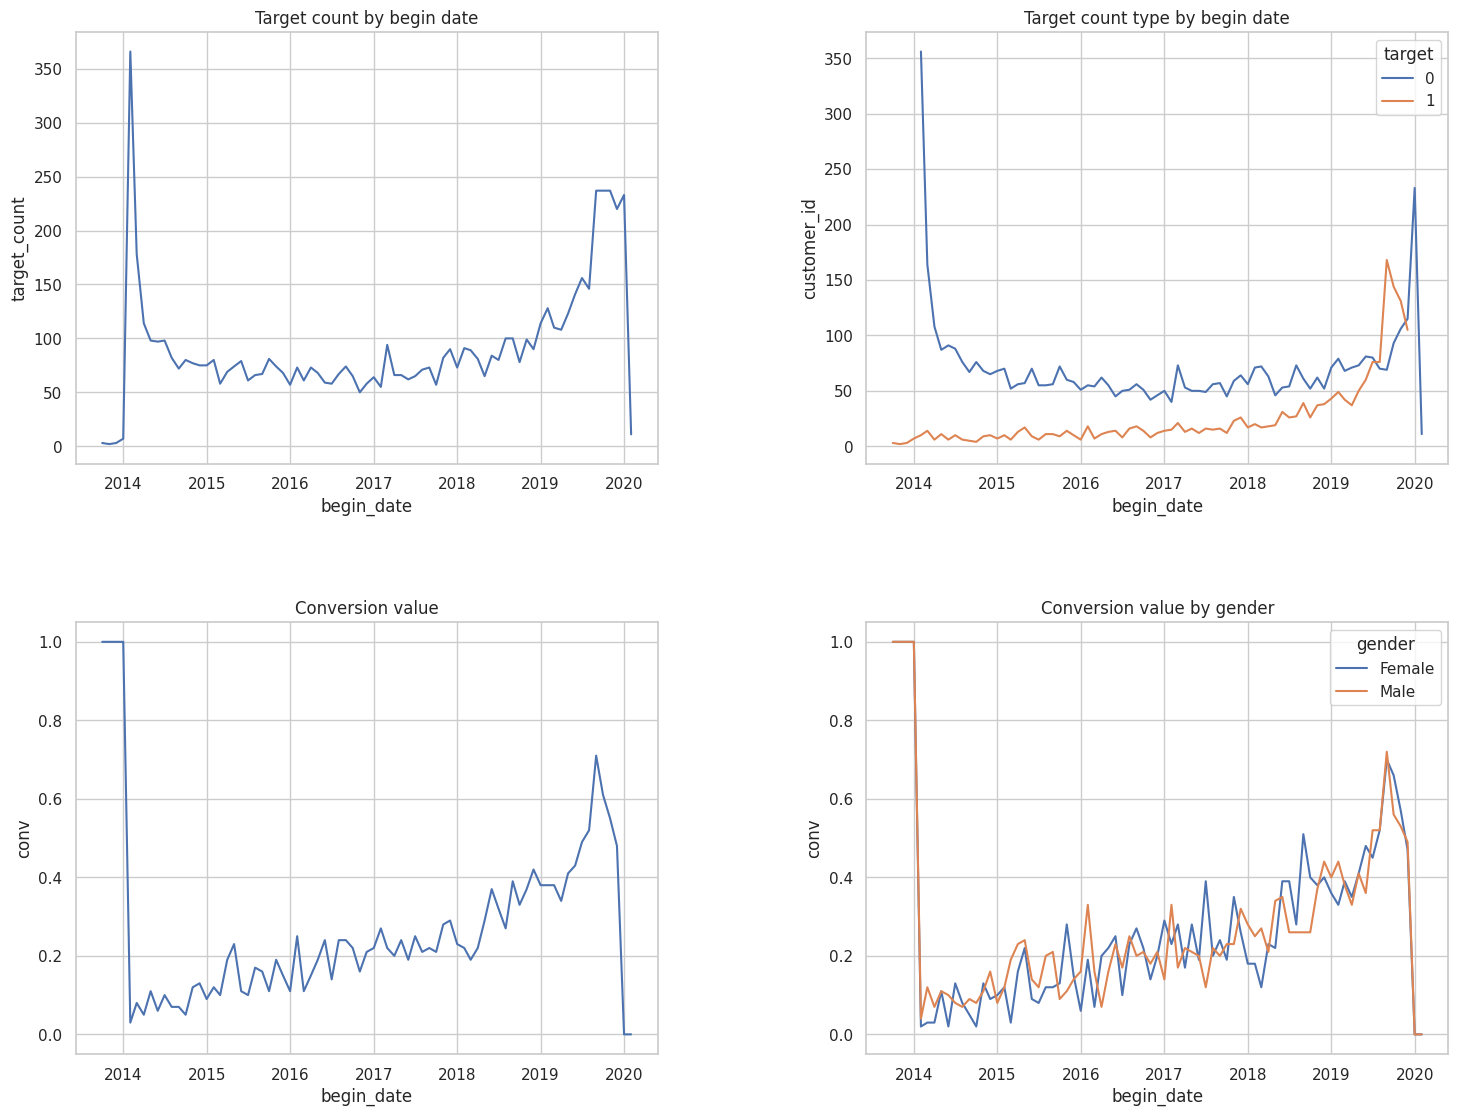

In [83]:
# установка переменных для анализа
x = "begin_date"
target = "target"

# определение статистики для агрегации
stat = ["count"]

# агрегация количества целей по датам начала с последующим сбросом индекса
target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index()
# удаление мультиуровневости заголовков после агрегации и переименование для удобства
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]

# подсчёт количества клиентов для каждого значения цели по датам
target_agg = df[[x, target, 'customer_id']].groupby([x, target]).count().reset_index() # ваш код здесь #

# расчёт суммы и количества для конверсии по датам
conversion_agg = df[[x, target]].groupby([x])['target'].agg(['sum', 'count']).reset_index()
# вычисление коэффициента конверсии и округление до двух знаков
coef = df.target.sum()
conversion_agg['conv'] = (conversion_agg['sum'] / conversion_agg['count']).round(2) # ваш код здесь #

# аналогичный расчет конверсии, но с дополнительным разделением по полу
conversion_agg_gender = df[[x, target, 'gender']].groupby([x, 'gender'])[target].agg(['sum', 'count']).reset_index()
conversion_agg_gender['conv'] = (conversion_agg_gender['sum'] / conversion_agg_gender['count']).round(2)

# инициализация фигуры для отображения нескольких графиков
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)  # настройка отступов между подграфиками
fig.set_size_inches(16.5, 12.5, forward=True)  # установка размера фигуры

# визуализация общего количества целей по датам начала
sns.lineplot(data=target_agg_by_date, x=x, y='target_count', ax=axs[0, 0])
axs[0, 0].set_title("Target count by begin date")

# визуализация количества клиентов для каждого типа цели по датам
# ваш код здесь #
sns.lineplot(data=target_agg, x=x, y='customer_id', hue=target, ax=axs[0, 1])
axs[0, 1].set_title("Target count type by begin date")

# визуализация коэффициента конверсии по датам
# ваш код здесь #
sns.lineplot(data=conversion_agg, x=x, y="conv", ax=axs[1, 0])
axs[1, 0].set_title("Conversion value")

# визуализация коэффициента конверсии по датам с разделением по полу
sns.lineplot(data=conversion_agg_gender, x=x, y='conv', hue='gender', ax=axs[1, 1])
axs[1, 1].set_title("Conversion value by gender")

# сохранение визуализации в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_by_date'))
# ваш код здесь #

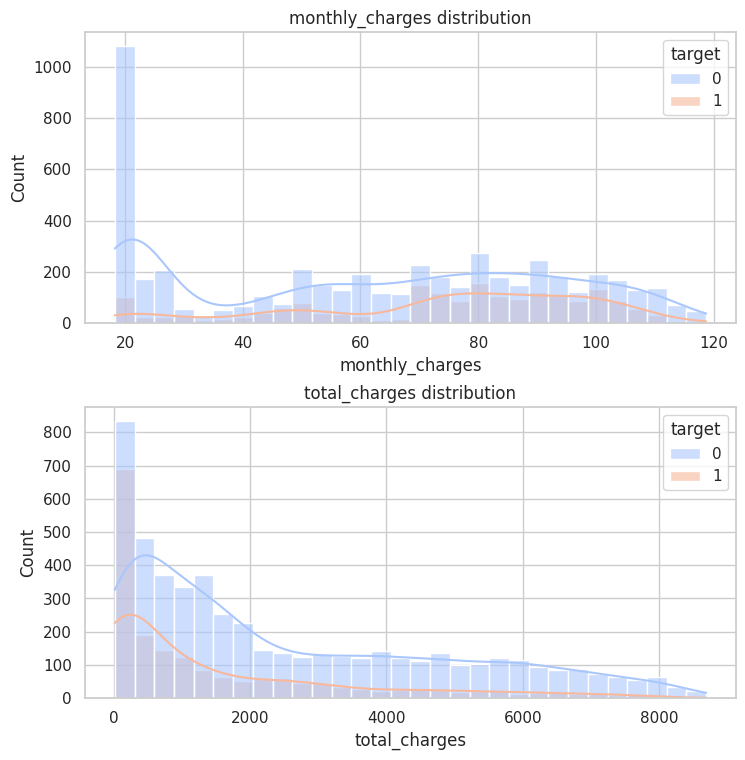

In [92]:
charges = ["monthly_charges", "total_charges"]
target = "target"

# Инициализация фигуры для отображения гистограмм
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
fig.tight_layout(pad=3)  # Настройка отступов между подграфиками

# Визуализация распределения ежемесячных платежей (monthly_charges) с разделением по target
sns.histplot(data=df, x=charges[0], hue=target, kde=True, bins=30, ax=axs[0], palette="coolwarm", alpha=0.6)
axs[0].set_title(f"{charges[0]} distribution")  # Установка заголовка

# Визуализация распределения общих платежей (total_charges) с разделением по target
sns.histplot(data=df, x=charges[1], hue=target, kde=True, bins=30, ax=axs[1], palette="coolwarm", alpha=0.6)
axs[1].set_title(f"{charges[1]} distribution")  # Установка заголовка

# Сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'chargest_by_target_dist'))
# Отображение графиков
plt.show()

In [103]:
mlflow.set_registry_uri(f'http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}')
mlflow.set_tracking_uri(f'http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}')

In [104]:
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

In [106]:
with mlflow.start_run(experiment_id=experiment_id, run_name=RUN_NAME) as run:
    run_id = run.info.run_id

    mlflow.log_artifact(ASSETS_DIR)

In [107]:
run_id

'f6d4bcf00e7b416b89fc7c8c740ad16d'